Author: Nicolai Wolpert  
Email: nicolai.wolpert@capgemini.com  
Date: July 2024

Script to test BERT transformer models to predict patient symptoms from gynéco text files. This script is adapted to run on kaggle for memory reasons (takes much too long on local PC).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/endopaths-data/dictionnaire_correction.json
/kaggle/input/endopaths-data/Recueil (1).xlsx
/kaggle/input/endopaths-data/donnees_entree_nlp_sans_endo.csv
/kaggle/input/endopaths-data/data_gynco_manual_extraction.xlsx


In [2]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
import re
#pd.set_option('display.max_rows', 10)
from matplotlib import pyplot as plt
import seaborn as sns
import string
import json

# Utils for NLP : 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, hamming_loss, accuracy_score, jaccard_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

from tqdm.notebook import tqdm

from datasets.dataset_dict import DatasetDict
from datasets import Dataset

import pickle

2024-10-29 13:30:22.064996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 13:30:22.065114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 13:30:22.202173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
pretrained_model = 'camembert-base' # e.g. 'camembert-base' or 'almanach/camembert-large'

In [4]:
## Preprocess X 

def remove_special_characters(text):
    """
    Input: str : A string to clean from non alphanumeric characters
    Output: str : The same strings without non alphanumeric characters
    """
    # faire attention à " ' "
    text_temp = text
    for char in string.punctuation:
        if char in text:
            text_temp = text_temp.replace(char, ' ')
    return text_temp

def remove_accents(text):
    """
    Input: str : A string to clean from non alphanumeric characters
    Output: str : The same strings without non alphanumeric characters
    Author: Nicolai Wolpert
    Date: 20.06.2024
    """
    text_temp = unidecode(text)
    return text_temp

def lowercase_text(text):
    """
    Input: str : A string to lowercase
    Output: str : The same string lowercased
    """
    return text.lower()

def tokenize_words(text):
    """
    Input: str : A string to tokenize
    Output: list of str : A list of the tokens splitted from the input string
    """
    #TOFILL
    #list_words = text.split(' ')
    # Nicolai corrected 24.06.:
    list_words = re.findall(r"[\w']+", text)
    return list_words

def appliquer_correction(text, dict_json):
    return list(map(lambda x: replace_word(x, dict_json), re.split(r'[ /,.-]', text)))

def replace_word(x, dict_json):
    if x in set(dict_json.keys()):
        x= x.replace(x, dict_json[x])
    return x

def contract_list(liste:list()):
    liste_unique = []
    for elem in liste:
        liste_unique = liste_unique + elem
    return liste_unique

def contract_string(liste:list):
    string = ''
    for elem in liste:
        string = string + elem + ' '
    return string

def correction_series(text):
    dict_json = load_dict_correction()
    list_ = appliquer_correction(text, dict_json)
    return contract_string(list_)
    
def apply_spellcheck(text):
    spell = SpellChecker(language='fr')
    text_temp = spell.correction(text)
    if text_temp is not None:
        return text_temp
    else:
        return text

def load_dict_correction():
    import json
    path = '/kaggle/input/endopaths-data/dictionnaire_correction.json'
    with open(path) as json_file:
        dict_json = json.load(json_file)
    return dict_json

## Load data

In [5]:
target_feature = 'atcd.endo' #'irm.lusg' #'atcd.endo'
use_gyneco_manual = True
use_multiclass = True

# Loading X : 
df_nlp = pd.read_csv('/kaggle/input/endopaths-data/donnees_entree_nlp_sans_endo.csv', usecols=['Anonymisation', 'Date', 'Nature', 'Résumé'])
df_nlp_orig = df_nlp.copy()
print('X shape is :', df_nlp.shape)

# Loading Y : 
recueil_orig  = pd.read_excel('/kaggle/input/endopaths-data/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
#recueil_orig = recueil_orig[['Numéro anonymat', 'atcd.endo', 'irm.lusg', 'tv.douloureux', 'irm.externe', 'sf.dig.diarrhee', 'echo.lusg', 'echo.lusd', 'ef.hormone.dpc', 'effet.hormone', 'anapath.lusd', 'anapath.lusg', 'anapath.torus', 'anapath.autre']]
recueil = recueil_orig.copy()
recueil.replace(['Na', 'NA'], np.nan, inplace=True)
recueil = recueil.rename(columns={'Numéro anonymat': 'Anonymisation'})
def Binarisation(x):
    if x>1:
        x=1
    return x
# Note the target variable, if endometriosis is present or not (corresponds to the anapth columns but not 'autre')
recueil['endometriose'] = recueil.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
# Drop the anapath columns again
recueil = recueil[[c for c in recueil.columns if not c.startswith('anapath')]]
recueil = recueil[['Anonymisation'] + [target_feature]]

# Read the recueil version created by manually extracting infos from gyneco files
recueil_manual = pd.read_excel('/kaggle/input/endopaths-data/data_gynco_manual_extraction.xlsx')
recueil_manual = recueil_manual[['Anonymisation'] + [target_feature]]

# Optional: Instead of using 'recueil' as ground truth, use 'recueil_manual'
# Decide on what to predict: Info absent or present in gyneco, or symptom absent or present
prediction_goal = 'symptom_present'    # 'info_present' or 'symptom_present'
if use_gyneco_manual:
    print('Using infos extracted manually from gyneco files')
    recueil = recueil_manual.copy()

if prediction_goal == 'info_present':
    print(f'Target = predict whether info for {target_feature} is present in gyneco file or not')
    recueil[target_feature] = recueil[target_feature].replace({0: 1, np.nan: 0})
elif prediction_goal=='symptom_present':
    if use_multiclass:
        recueil[target_feature] = recueil[target_feature].replace({np.nan: 2})
    else:
        recueil = recueil[recueil[target_feature].notna()]

print('Y shape is :', recueil.shape)
print(f'Nombre de patientes dans le df_nlp : {len(df_nlp.Anonymisation.unique())}')
num_labels = len(pd.unique(recueil[target_feature]))
print(f'Nombre de classes pour {target_feature}: {num_labels}')

if 'DJ-055' in list(df_nlp['Anonymisation']):
    df_nlp.loc[df_nlp['Anonymisation']=='DJ-055', 'Anonymisation'] ='NJ-055'
'NJ-055' in list(df_nlp['Anonymisation'])
'DJ-055' in list(df_nlp['Anonymisation'])

X shape is : (1137, 4)


/tmp/ipykernel_24/2144318695.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil.replace(['Na', 'NA'], np.nan, inplace=True)


Using infos extracted manually from gyneco files
Y shape is : (176, 2)
Nombre de patientes dans le df_nlp : 178
Nombre de classes pour atcd.endo: 3


False

## Preprocessing

In [6]:
# IMPORTANT: Lowercase and removal of special characters has to be applied before 'correction_series', else words will not be found in the correction dictionnary
df_nlp.Résumé = df_nlp.Résumé.apply(remove_special_characters)
df_nlp.Résumé = df_nlp.Résumé.apply(lowercase_text)
df_nlp.Résumé = df_nlp.Résumé.apply(correction_series)
df_nlp

,Anonymisation,Date,Nature,Résumé
0,AA-071,2019-12-08,Ordonnance,1 en cas d hystéroscopie avant la ménopause ...
1,AA-071,2018-10-29,Ordonnance,rectosonographie échographie pelvienne avec c...
2,AA-071,2019-09-16,Ordonnance,cerazette 1 cp par jour sans interruption en...
3,AA-071,2019-09-17,Ordonnance,mopral 20 mg 1 gélule le soir pendant 15 jou...
4,AA-071,2021-04-05,Ordonnance,dispositif intra utérin hormonal mirena 1 un...
...,...,...,...,...
1132,7423767,2020-02-17,Consultation,suites opératoires simples métror 10 15j ablat...
1133,7423767,2020-02-17,Ordonnance,seasonique oar 1 an
1134,7423767,2020-02-17,Mots,suites opératoires simples métror 10 15j ablat...
1135,7423767,2020-06-01,Ordonnance,1 en cas d hystéroscopie avant la ménopause ...


In [7]:
df_nlp.sort_values('Anonymisation')

,Anonymisation,Date,Nature,Résumé
1128,6061322,2019-07-01,Ordonnance,faire pratiquer une échographie abdominales po...
1127,6061322,2019-05-06,Mots,amh reçu du 26 04 2019 1 4ng ml prl fsh lh ...
1126,6061322,2019-04-29,Mots,relecture irm par Dr maissiat image kystique...
1125,6061322,2019-04-23,Ordonnance,1 merci de réaliser une prise de sang dans un...
1136,7423767,2020-07-22,Mots,mail au Dr lesaca copie à a badoil cher con...
...,...,...,...,...
1119,YC-171,2021-03-05,Ordonnance,contrôle irm pelvienne afin d apprécier la rég...
1118,YC-171,2021-03-31,Ordonnance,paracétamol 1 g 1 cp toutes les 6h si douleu...
1124,YL-124,2020-10-09,Consultation,va bcp mieux moins de ballonnement et moins d...
1123,YL-124,2020-07-19,Mots,doute sur un petit épaississement nodulaire de...


## Data preparation for training

In [8]:
preprocess_mode = 'multiclass'      # 'multiclass' = garder les nan et les traiter comme classe, 'dropnan' = enlever les nan

# Merge recueil and nlp dataframes and rename columns
merge_documents_per_patient = True    # if true, appends all texts for a given patient to one
if merge_documents_per_patient:
    df_nlp = df_nlp.groupby('Anonymisation')['Résumé'].agg(' '.join).reset_index()
if not use_gyneco_manual:
    df_nlp = df_nlp.loc[df_nlp.Anonymisation.isin(list(recueil.Anonymisation))]
data = pd.merge(df_nlp, recueil, on='Anonymisation', how='inner')
data = data.rename(columns={'Anonymisation': 'patient', 'Résumé': 'text', target_feature: 'outcome'})
# Format labels
def label_outcome(row):
    if row['outcome'] == 0:
        return 'absent'
    elif row['outcome'] == 1:
        return 'present'
    elif row['outcome'] == 2:
        return 'ambigue'
data['str_outcome'] = data.apply(label_outcome, axis=1)

### Treat missing values as class or drop them

if preprocess_mode == 'dropnan':
    data.outcome = data.outcome.fillna(2.0)
    data['outcome'] = data['outcome'].astype(int)
nclasses = len(np.unique(data['outcome']))
data

,patient,text,outcome,str_outcome
0,AA-071,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue
1,AB-067,rééducation vesico périnéale pour iu mixte hyp...,1.0,present
2,AC-131,difficulté post opus avec douleur abdo et ball...,1.0,present
3,AE-060,appel téléphonique patiente moins douloureuse...,1.0,present
4,AE-062,rectosonographie échographie pelvienne avec c...,1.0,present
...,...,...,...,...
150,WL-197,je sous signée cuq juliette interne en médecin...,1.0,present
151,WM-073,1 en cas d hystéroscopie avant la ménopause ...,1.0,present
152,WM-089,rectosonographie échographie pelvienne avec c...,1.0,present
153,YC-171,dienogest comprimé à 2 mg sawis dimetrum ...,1.0,present


In [9]:
df_nlp.groupby('Anonymisation')['Résumé'].agg(' '.join).reset_index()

,Anonymisation,Résumé
0,6061322,1 merci de réaliser une prise de sang dans un...
1,7423767,rectosonographie échographie pelvienne avec c...
2,AA-071,1 en cas d hystéroscopie avant la ménopause ...
3,AB-067,rééducation vesico périnéale pour iu mixte hyp...
4,AC-131,difficulté post opus avec douleur abdo et ball...
...,...,...
173,WL-197,je sous signée cuq juliette interne en médecin...
174,WM-073,1 en cas d hystéroscopie avant la ménopause ...
175,WM-089,rectosonographie échographie pelvienne avec c...
176,YC-171,dienogest comprimé à 2 mg sawis dimetrum ...


In [10]:
df_nlp.sort_values('Anonymisation')

,Anonymisation,Résumé
0,6061322,1 merci de réaliser une prise de sang dans un...
1,7423767,rectosonographie échographie pelvienne avec c...
2,AA-071,1 en cas d hystéroscopie avant la ménopause ...
3,AB-067,rééducation vesico périnéale pour iu mixte hyp...
4,AC-131,difficulté post opus avec douleur abdo et ball...
...,...,...
173,WL-197,je sous signée cuq juliette interne en médecin...
174,WM-073,1 en cas d hystéroscopie avant la ménopause ...
175,WM-089,rectosonographie échographie pelvienne avec c...
176,YC-171,dienogest comprimé à 2 mg sawis dimetrum ...


Number of patients with info missing: 74
Number of patients with symptom present: 94
Number of patients with symptom absent: 8


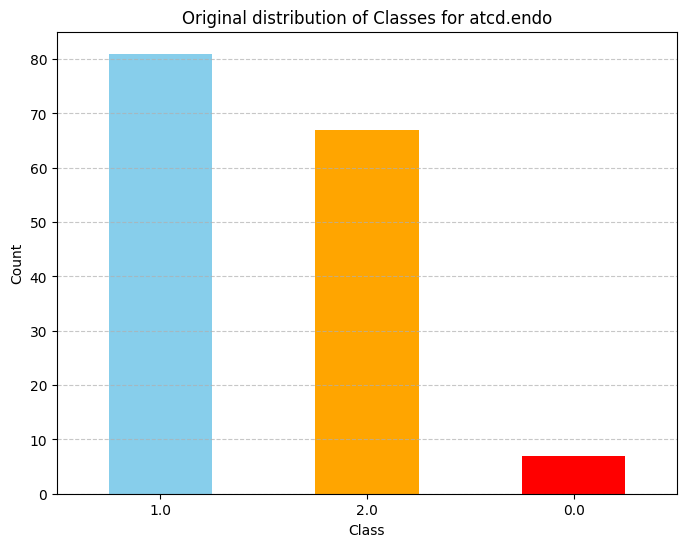

In [11]:
# Calculate the distribution of classes for the selected feature
recueil_manual_plot = pd.merge(df_nlp, recueil, on='Anonymisation', how='inner')
recueil_manual_plot[target_feature] = recueil_manual_plot[target_feature].replace({np.nan: 2})
class_counts = recueil_manual_plot[target_feature].value_counts()

nmissing = recueil.loc[recueil[target_feature]==2].shape[0]
npresent = recueil.loc[recueil[target_feature]==1].shape[0]
nabsent = recueil.loc[recueil[target_feature]==0].shape[0]
print(f'Number of patients with info missing: {nmissing}')
print(f'Number of patients with symptom present: {npresent}')
print(f'Number of patients with symptom absent: {nabsent}')

# Create a bar plot
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange', 'red'])
plt.title(f'Original distribution of Classes for {target_feature}')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [12]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast = False)

def tokenize_batch(samples, tokenizer, max_length):
    text = [sample["text"] for sample in samples]
    labels = torch.tensor([sample["outcome"] for sample in samples])
    str_labels = [sample["str_outcome"] for sample in samples]
    # The tokenizer handles
    # - Tokenization
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    #tokens = tokenizer(text, padding="longest", return_tensors="pt")
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    
    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Train/Val/Test split

In [13]:
pd.unique(data['str_outcome'])

array(['ambigue', 'present', 'absent'], dtype=object)

In [14]:
prop_train = 0.8
prop_val = 0.1
prop_test = 0.1

# Choose how to split: 
# 'patientwise': On patient-level (such that no patient is in the train and val/test set)
# 'patientmix': Not seperating patients in train vs. val/test set
method_split = 'patientwise'

### Split based on patients
if method_split == 'patientwise':
    patient_outcomes = data.groupby('patient')['outcome'].max().reset_index()
    patient_outcomes['nrows'] = list(data['patient'].value_counts())

    train_patients, test_patients = train_test_split(
        patient_outcomes,
        test_size=prop_test,
        stratify=patient_outcomes['outcome'],
        random_state=42
    )

    train_patients, val_patients = train_test_split(
        train_patients,
        test_size=0.125,
        stratify=train_patients['outcome'],
        random_state=42
    )

    train = data.loc[data.patient.isin(list(train_patients.patient))]
    val = data.loc[data.patient.isin(list(val_patients.patient))]
    test = data.loc[data.patient.isin(list(test_patients.patient))]

    npatients_train = len(pd.unique(train.patient))
    npatients_val = len(pd.unique(val.patient))
    npatients_test = len(pd.unique(test.patient))

    print(f'Number of patients in train set: {npatients_train}')
    print(f'Number of patients in validation set: {npatients_val}')
    print(f'Number of patients in test set: {npatients_test}')

### Simple approach, patients mixed in train and val/test
else:
    train, test = train_test_split(data, random_state=42, test_size=prop_test, stratify=data['outcome'])
    train, val = train_test_split(train, random_state=42, test_size=0.125, stratify=train['outcome'])

    print(f'Number of samples in train set: {train.shape[0]}, = {round((train.shape[0]/data.shape[0])*100, 2)} %')
    print(f'Number of samples in validation set: {val.shape[0]}, = {round((val.shape[0]/data.shape[0])*100, 2)} %')
    print(f'Number of samples in test set: {test.shape[0]}, = {round((test.shape[0]/data.shape[0])*100, 2)} %')

train_original = train.copy()

Number of patients in train set: 121
Number of patients in validation set: 18
Number of patients in test set: 16


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


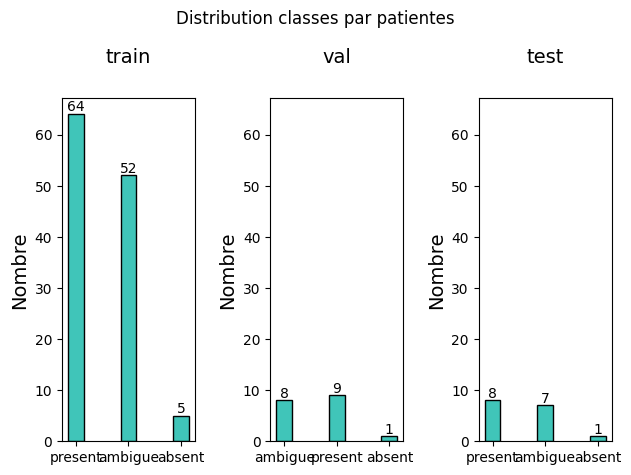

In [15]:
# Vérifier distribution des classes dans train/val/test
fig, axs = plt.subplots(nrows=1, ncols=3)
axs = axs.flatten()
sns.histplot(data=train_patients['outcome'].map({0: 'absent', 1: 'present', 2: 'ambigue'}), shrink=0.3, color='#00B2A2', ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Nombre', fontsize=14)
axs[0].set_title('train', pad=25, fontsize=14)
sns.histplot(data=val_patients['outcome'].map({0: 'absent', 1: 'present', 2: 'ambigue'}), shrink=0.3, color='#00B2A2', ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xlabel('')
axs[1].set_ylabel('Nombre', fontsize=14)
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_title('val', pad=25, fontsize=14)
sns.histplot(data=test_patients['outcome'].map({0: 'absent', 1: 'present', 2: 'ambigue'}), shrink=0.3, color='#00B2A2', ax=axs[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_xlabel('')
axs[2].set_ylabel('Nombre', fontsize=14)
axs[2].set_ylim(axs[0].get_ylim())
axs[2].set_title('test', pad=25, fontsize=14)
plt.suptitle('Distribution classes par patientes')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


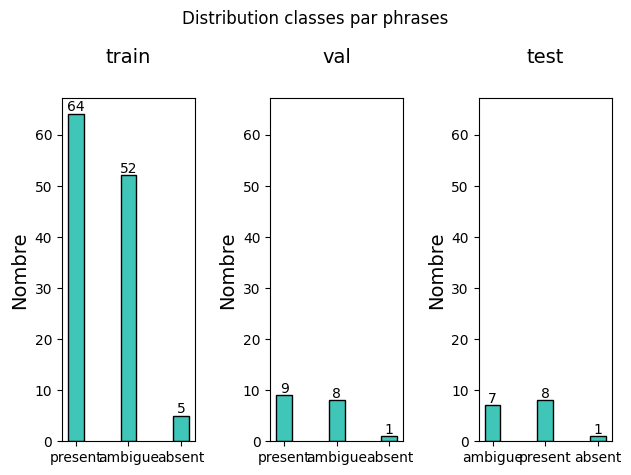

In [16]:
# Vérifier bonne distribution des classes dans train/val/test
fig, axs = plt.subplots(nrows=1, ncols=3)
axs = axs.flatten()
sns.histplot(data=train['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Nombre', fontsize=14)
axs[0].set_title('train', pad=25, fontsize=14)
sns.histplot(data=val['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xlabel('')
axs[1].set_ylabel('Nombre', fontsize=14)
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_title('val', pad=25, fontsize=14)
sns.histplot(data=test['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_xlabel('')
axs[2].set_ylabel('Nombre', fontsize=14)
axs[2].set_ylim(axs[0].get_ylim())
axs[2].set_title('test', pad=25, fontsize=14)
plt.suptitle('Distribution classes par phrases')
plt.tight_layout()
plt.show()

### Optional: Upsampling or downsampling to correct class imbalance

In [17]:
data_positive_train = (train['outcome'] == 1.0).sum()
data_negative_train = (train['outcome'] == 0.0).sum()
data_ambiguous_train = (train['outcome'] == 2.0).sum()
print('positive data in training:', data_positive_train)
print('negative data in training:', data_negative_train)
print('ambiguous data in training:', data_ambiguous_train)
print()
print('positive data in validation:',(val['outcome'] == 1.0).sum())
print('negative data in validation:',(val['outcome'] == 0.0).sum())
print('ambiguous data in validation:',(val['outcome'] == 2.0).sum())
print()
print('positive data in test:',(test['outcome'] == 1.0).sum())
print('negative data in test:',(test['outcome'] == 0.0).sum())
print('ambiguous data in test:',(test['outcome'] == 2.0).sum())

positive data in training: 64
negative data in training: 5
ambiguous data in training: 52

positive data in validation: 9
negative data in validation: 1
ambiguous data in validation: 8

positive data in test: 8
negative data in test: 1
ambiguous data in test: 7


majority class before upsampling: (64, 4)
minority class 1 before upsampling: (5, 4)
minority class 2 before upsampling: (52, 4)
After upsampling
outcome
1.0    64
0.0    64
2.0    64
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


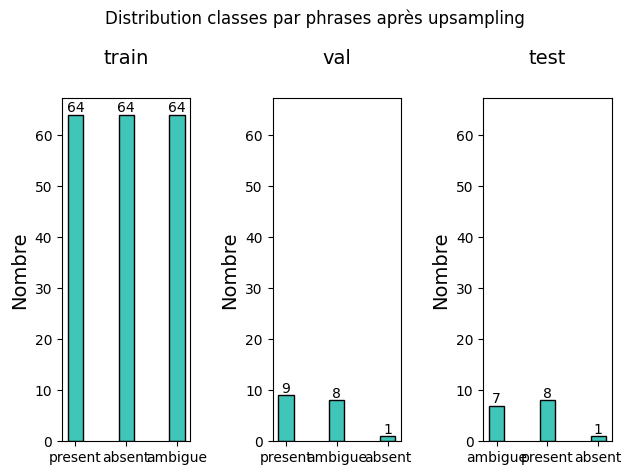

In [18]:
balance_method = 'upsampling'

# Separate majority and minority classes in training data for upsampling
if nclasses==2:
    if data_positive_train == np.max([data_positive_train, data_negative_train]):
        data_train_majority = train[train['outcome'] == 1.0]
        data_train_minority = train[train['outcome'] == 0.0]
    elif data_negative_train == np.max([data_positive_train, data_negative_train]):
        data_train_majority = train[train['outcome'] == 0.0]
        data_train_minority = train[train['outcome'] == 1.0]
elif nclasses==3:
    if data_positive_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = train[train['outcome'] == 1.0]
        data_train_minority1 = train[train['outcome'] == 0.0]
        data_train_minority2 = train[train['outcome'] == 2.0]
    elif data_negative_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = train[train['outcome'] == 0.0]
        data_train_minority1 = train[train['outcome'] == 1.0]
        data_train_minority2 = train[train['outcome'] == 2.0]
    elif data_ambiguous_train == np.max([data_positive_train, data_negative_train, data_ambiguous_train]):
        data_train_majority = train[train['outcome'] == 2.0]
        data_train_minority1 = train[train['outcome'] == 0.0]
        data_train_minority2 = train[train['outcome'] == 1.0]
    
if balance_method=='upsampling':
    
    if nclasses==2:
        print("majority class before upsampling:",data_train_majority.shape)
        print("minority class before upsampling:",data_train_minority.shape)
        
        # Upsample minority class 1
        data_train_minority_upsampled = resample(data_train_minority, 
                                        replace=True,     # sample with replacement
                                        n_samples= data_train_majority.shape[0],    # to match majority class
                                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        data_train_upsampled = pd.concat([data_train_majority, data_train_minority_upsampled])
        
        # Display new class counts
        print("After upsampling\n",data_train_upsampled['outcome'].value_counts(),sep = "")

    elif nclasses==3:
        print("majority class before upsampling:",data_train_majority.shape)
        print("minority class 1 before upsampling:",data_train_minority1.shape)
        print("minority class 2 before upsampling:",data_train_minority2.shape)

        # Upsample minority class 1
        data_train_minority1_upsampled = resample(data_train_minority1, 
                                        replace=True,     # sample with replacement
                                        n_samples= data_train_majority.shape[0],    # to match majority class
                                        random_state=123) # reproducible results
        # Upsample minority class 2
        data_train_minority2_upsampled = resample(data_train_minority2, 
                                        replace=True,     # sample with replacement
                                        n_samples= data_train_majority.shape[0],    # to match majority class
                                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        data_train_upsampled = pd.concat([data_train_majority, data_train_minority1_upsampled, data_train_minority2_upsampled])

        # Display new class counts
        print("After upsampling\n",data_train_upsampled['outcome'].value_counts(),sep = "")

    train = data_train_upsampled.copy()

# Not recommended since it results in huge data loss - just to test out performance of model with completely balanced data distribution
elif balance_method=='downsampling':
    
    if nclasses==2:
        minimum_number_of_patients_per_class = np.min([data_positive_train, data_negative_train])

        ### Remove samples from the majority class
        train_original = train.copy()
        train_negative = train.loc[train.outcome==0]
        train_positive = train.loc[train.outcome==1]

        if train_negative.shape[0] > train_positive.shape[0]:
            data_train_majority = train_negative
            data_train_minority = train_positive
        else:
            data_train_majority = train_positive
            data_train_minority = train_negative

        train_negative = train_negative.sample(n=minimum_number_of_patients_per_class, replace=False, random_state=1)
        train_positive = train_positive.sample(n=minimum_number_of_patients_per_class, replace=False, random_state=1)

        # Combine majority class with downsampled majority class
        train_downsampled = pd.concat([train_negative, train_positive])
    elif nclasses==3:
        minimum_number_of_patients_per_class = np.min([data_positive_train, data_negative_train, data_ambiguous_train])

        ### Remove samples from the majority class
        train_original = train.copy()
        train_negative = train.loc[train.outcome==0]
        train_positive = train.loc[train.outcome==1]
        train_missing = train.loc[train.outcome==2]

        if train_negative.shape[0] > train_positive.shape[0]:
            data_train_majority = train_negative
            data_train_minority = train_positive
        else:
            data_train_majority = train_positive
            data_train_minority = train_negative

        train_negative = train_negative.sample(n=minimum_number_of_patients_per_class, replace=False, random_state=1)
        train_positive = train_positive.sample(n=minimum_number_of_patients_per_class, replace=False, random_state=1)
        train_missing = train_missing.sample(n=minimum_number_of_patients_per_class, replace=False, random_state=1)

        # Combine majority class with downsampled majority class
        train_downsampled = pd.concat([train_negative, train_positive, train_missing])
    
    train = train_downsampled.copy()
    
# Vérifier bonne distribution des classes dans train/val/test
fig, axs = plt.subplots(nrows=1, ncols=3)
axs = axs.flatten()
sns.histplot(data=train['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('Nombre', fontsize=14)
axs[0].set_title('train', pad=25, fontsize=14)
sns.histplot(data=val['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xlabel('')
axs[1].set_ylabel('Nombre', fontsize=14)
axs[1].set_ylim(axs[0].get_ylim())
axs[1].set_title('val', pad=25, fontsize=14)
sns.histplot(data=test['str_outcome'], shrink=0.3, color='#00B2A2', ax=axs[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_xlabel('')
axs[2].set_ylabel('Nombre', fontsize=14)
axs[2].set_ylim(axs[0].get_ylim())
axs[2].set_title('test', pad=25, fontsize=14)
plt.suptitle('Distribution classes par phrases après upsampling')
plt.tight_layout()
plt.show()

### Transformation to DataLoader format

In [19]:
# Transformer les données en format qui peut être lu dans les librairies 'HuggingFace'

max_length = 512

train_dataset = Dataset.from_pandas(train.sample(n=train.shape[0], random_state=1))  # shuffle
val_dataset = Dataset.from_pandas(val.sample(n=val.shape[0], random_state=1))
test_dataset = Dataset.from_pandas(test.sample(n=test.shape[0], random_state=1))

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

train_dataloader = DataLoader(
    dataset["train"], 
    batch_size=16,
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)
val_dataloader = DataLoader(
    dataset["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)
test_dataloader = DataLoader(
    dataset["test"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer, max_length=max_length)
)

In [20]:
train

,patient,text,outcome,str_outcome
1,AB-067,rééducation vesico périnéale pour iu mixte hyp...,1.0,present
2,AC-131,difficulté post opus avec douleur abdo et ball...,1.0,present
4,AE-062,rectosonographie échographie pelvienne avec c...,1.0,present
5,AM-023,patiente de 30 ans atcd chirurgie 0 med ...,1.0,present
6,AM-038,Dr le bail Dr gay soare ffi bien soulagée ...,1.0,present
...,...,...,...,...
111,NL-042,1 laroxyl 5 à 15 gouttes le soir au coucher ...,2.0,ambigue
61,FE-135,clomid 1 comprimé s par jour du 2ème...,2.0,ambigue
112,NN-075,optimizette 1 plaquette mois oar 6 mois ...,2.0,ambigue
65,GJ-018,le couple est revue en consultation car appel ...,2.0,ambigue


In [21]:
test

,patient,text,outcome,str_outcome
0,AA-071,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue
3,AE-060,appel téléphonique patiente moins douloureuse...,1.0,present
30,CB-145,pour les douleurs vaginales superficielles hu...,2.0,ambigue
35,CE-074,Pr dubernard pas de projet grossesse Pr 12a...,1.0,present
37,CG-111,pharmacie desogestrel 0 075 mg comprimés pr...,1.0,present
40,CM-103,1 paire de chaussettes de contention force 2 ...,1.0,present
52,DS-004,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue
56,EM-049,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue
82,KF-190,rectosonographie échographie pelvienne avec c...,2.0,ambigue
91,LC-142,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue


## Training

In [22]:
learning_rate = 3e-5 #3e-5
# Choose loss function: Either 'crossentropyloss', 'weightedcrossentropyloss' or 'focalloss'
loss_function = 'crossentropyloss'

# Calculate class weights
if loss_function=='weightedcrossentropyloss':
    class_weights = compute_class_weight(class_weight="balanced", classes=pd.unique(train_original['outcome']), y=train_original['outcome'].values)  # Using train_original because in case upsampling is used as well, compute weights without taking duplicate samples into account
    class_weights = torch.tensor(class_weights,dtype=torch.float)
    print('Class weights:')
    print(class_weights)
else:
    class_weights = None

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=6, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [24]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, loss_function, class_weights=None, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.lr = lr
        self.weight_decay = weight_decay
        self.loss_function = loss_function
        self.class_weights = class_weights
        self.num_labels = self.model.num_labels
        print(f'Number of labels: {self.num_labels}')

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch, batch_idx):
        # Move batch to the correct device
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)
        #labels = batch["labels"].to(self.device)   # Changed 23.10.24
        labels = batch["labels"].to(self.device).long()
        assert labels.min() >= 0 and labels.max() < self.num_labels, f"Labels should be between 0 and {self.num_labels - 1}"

        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = out.logits
        
        # Define the loss function based on the chosen type
        if self.loss_function == 'crossentropyloss':
            loss_fn = nn.CrossEntropyLoss()
        elif self.loss_function == 'weightedcrossentropyloss':
            if self.class_weights is not None:
                class_weights = self.class_weights.to(self.device)
            else:
                raise ValueError('class_weights must be provided for weightedcrossentropyloss')
            loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        elif self.loss_function == 'focalloss':
            loss_fn = FocalLoss()
        else:
            raise ValueError(f'Invalid loss function specified: {self.loss_function}')
        
        loss = loss_fn(logits.view(-1, self.num_labels), labels.view(-1))
        
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)
        labels = batch["labels"].to(self.device)

        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = out.logits

        preds = torch.argmax(logits, dim=-1)
        acc = (labels == preds).float().mean()
        f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average="macro")
        
        self.log("valid/acc", acc, prog_bar=True, logger=True)
        self.log("valid/f1", f1, prog_bar=True, logger=True)
        
        return acc

    def predict_step(self, batch, batch_idx):
        input_ids = batch["input_ids"].to(self.device)
        attention_mask = batch["attention_mask"].to(self.device)

        out = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return torch.argmax(out.logits, dim=-1)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [25]:
target_feature_txt = target_feature.replace('.', '_')
model_checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="valid/acc", 
    mode="max",
    dirpath='/kaggle/working/',
    filename=f'{pretrained_model}_{target_feature_txt}_split_{method_split}_learning_rate_{learning_rate}_{loss_function}_{balance_method}',
    save_top_k=1,
    save_weights_only=True
)

# Set up CSV logger
csv_logger = CSVLogger("logs", name="camembert_training")
camembert_trainer = pl.Trainer(
    max_epochs=20,
    #gpus=1,
    logger=csv_logger,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

In [26]:
lightning_model = LightningModel(pretrained_model, num_labels, lr=learning_rate, weight_decay=0., loss_function=loss_function, class_weights=class_weights)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of labels: 3


In [27]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [28]:
### Evaluate performance

# Load the best model checkpoint
best_model_path = model_checkpoint.best_model_path
best_model = LightningModel.load_from_checkpoint(best_model_path, model_name=pretrained_model, num_labels=num_labels, lr=3e-5, weight_decay=0.)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Predict on the test dataset
predictions = []
true_labels = []

best_model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculations for inference
    for batch in test_dataloader:
        # Assuming batch is a dictionary
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Prepare batch dictionary
        batch_dict = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }
        
        # Get predictions
        preds = best_model.predict_step(batch_dict, batch_idx=0).cpu().numpy()
        labels = batch_dict["labels"].cpu().numpy()
        
        predictions.extend(preds)
        true_labels.extend(labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of labels: 3
Accuracy: 0.3125
Precision: 0.2333
Recall: 0.2262
F1 Score: 0.2202
Confusion Matrix:
[[0 0 1]
 [0 2 6]
 [1 3 3]]


In [29]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.40      0.25      0.31         8
         2.0       0.30      0.43      0.35         7

    accuracy                           0.31        16
   macro avg       0.23      0.23      0.22        16
weighted avg       0.33      0.31      0.31        16



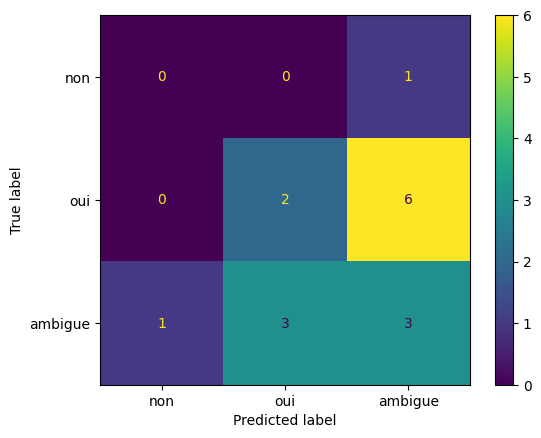

In [30]:
cm = confusion_matrix(true_labels, predictions)
if len(pd.unique(recueil[target_feature]))==2:
    labels=['non', 'oui']
else:
    labels=['non', 'oui', 'ambigue']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [31]:
## Show performance by patient
# Merge predictions patient-wise (since we have several texts per patient), choosing the most frequent prediction

if not merge_documents_per_patient:
    test.loc[:, 'predictions'] = predictions
    predictions_per_patient_text = test.sort_values('patient', ascending=True).groupby('patient')['predictions'].value_counts()
    predictions_by_patient_majority = []
    for patient in pd.unique(test.patient):
        # In case the number of predictions for the classes are the same, assign most frequent outcome
        if (predictions_per_patient_text[patient].shape[0]==2) and (predictions_per_patient_text[patient].loc[0] == predictions_per_patient_text[patient].loc[1]):
            predictions_by_patient_majority = predictions_by_patient_majority + [test['outcome'].value_counts().nlargest(1).index[0]]
        else:
            predictions_by_patient_majority = predictions_by_patient_majority + [predictions_per_patient_text[patient].idxmax()]

    true_classes_by_patient = list(test.drop_duplicates(subset='patient').sort_values('patient', ascending=True)['outcome'])

    if len(predictions_by_patient_majority) != len(true_classes_by_patient):
        raise ValueError('Mismatch in the number of samples')

    # Calculate evaluation metrics if the lengths match
    accuracy_by_patient_majority = accuracy_score(true_classes_by_patient, predictions_by_patient_majority)
    precision_by_patient_majority = precision_score(true_classes_by_patient, predictions_by_patient_majority, average='macro')
    recall_by_patient_majority = recall_score(true_classes_by_patient, predictions_by_patient_majority, average='macro')
    f1_by_patient_majority = f1_score(true_classes_by_patient, predictions_by_patient_majority, average='macro')
    conf_matrix_by_patient_majority = confusion_matrix(true_classes_by_patient, predictions_by_patient_majority)

    print('##### Performance patient-wise:')
    print(f'Accuracy: {accuracy_by_patient_majority:.4f}')
    print(f'Precision: {precision_by_patient_majority:.4f}')
    print(f'Recall: {recall_by_patient_majority:.4f}')
    print(f'F1 Score: {f1_by_patient_majority:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix_by_patient_majority)

In [32]:
test['predictions'] = predictions
test

/tmp/ipykernel_24/2452099908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions


,patient,text,outcome,str_outcome,predictions
0,AA-071,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue,2
3,AE-060,appel téléphonique patiente moins douloureuse...,1.0,present,2
30,CB-145,pour les douleurs vaginales superficielles hu...,2.0,ambigue,1
35,CE-074,Pr dubernard pas de projet grossesse Pr 12a...,1.0,present,2
37,CG-111,pharmacie desogestrel 0 075 mg comprimés pr...,1.0,present,1
40,CM-103,1 paire de chaussettes de contention force 2 ...,1.0,present,1
52,DS-004,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue,2
56,EM-049,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue,2
82,KF-190,rectosonographie échographie pelvienne avec c...,2.0,ambigue,2
91,LC-142,1 en cas d hystéroscopie avant la ménopause ...,2.0,ambigue,1


In [33]:
test.predictions.value_counts()

predictions
2    10
1     5
0     1
Name: count, dtype: int64

In [34]:
train.outcome.value_counts()

outcome
1.0    64
0.0    64
2.0    64
Name: count, dtype: int64

In [35]:
train.outcome.value_counts()

outcome
1.0    64
0.0    64
2.0    64
Name: count, dtype: int64

In [36]:
target_feature_txt = target_feature.replace('.', '_')
pickle.dump(camembert_trainer, open('/kaggle/working/' + f'{pretrained_model}_{target_feature_txt}_split_{method_split}_learning_rate_{learning_rate}_{loss_function}_{balance_method}', 'wb'))

### Exploration